In [14]:
import torch
import os

os.chdir('/import/home2/yhchenmath/Code/CellSegmentation/')

from utils.experiman import ExperiMan
from options import Options, HParams

manager = ExperiMan(name='default')
parser = manager.get_basic_arg_parser()
opt = Options(parser).parse()  # get training options
manager.setup(opt)
opt = HParams(**vars(opt))

======> UID of this run: 230725-170422-5ky21y
run_number : 0
Directory /import/home2/yhchenmath/Log/CellSeg/SCS/UNDEFINED/0 exists, please choose an option:
Old files deleted.
======> Directory for this run: /import/home2/yhchenmath/Log/CellSeg/SCS/UNDEFINED/0
2023-07-25 17:04:23,454 INFO Opts: Namespace(dataset={'name': 'scs_mouse_brain', 'loc': 'SCS', 'patch_size': 1200}, gpu='0', code_dir='./', data_dir='/import/home2/yhchenmath/Dataset/CellSeg', log_dir='/import/home2/yhchenmath/Log/CellSeg', exp_name='SCS', run_name='UNDEFINED', run_number='0', seed=0, option_for_existing_dir=None, load_json=True, json_path='./configs/mouse_adult_brain.json', mode='train', uid='230725-170422-5ky21y')
2023-07-25 17:04:23,454 INFO Opts: Namespace(dataset={'name': 'scs_mouse_brain', 'loc': 'SCS', 'patch_size': 1200}, gpu='0', code_dir='./', data_dir='/import/home2/yhchenmath/Dataset/CellSeg', log_dir='/import/home2/yhchenmath/Log/CellSeg', exp_name='SCS', run_name='UNDEFINED', run_number='0', seed=0,

In [2]:
import pandas as pd
df = pd.read_csv('/import/home2/yhchenmath/Dataset/CellSeg/SCS/Mouse_brain_Adult_GEM_bin1.tsv', sep='\t')

In [3]:
df

,geneID,x,y,MIDCounts
0,0610005C13Rik,11864,11748,3
1,0610005C13Rik,6632,9074,1
2,0610005C13Rik,10339,15898,2
3,0610005C13Rik,4290,10831,2
4,0610005C13Rik,5714,9053,2
...,...,...,...,...
80768696,mt-Nd6,8991,8056,1
80768697,mt-Nd6,5978,10911,1
80768698,mt-Nd6,6674,16975,1
80768699,mt-Nd6,9708,7116,1


In [4]:
min(df['x']),min(df['y'])

(3225, 6175)

In [5]:
data_dir = '/import/home2/yhchenmath/Dataset/CellSeg/SCS/'
sub_tsv = os.path.join(data_dir, "Mouse_brain_Adult_GEM_bin1_sub.tsv")
tif = '/import/home2/yhchenmath/Dataset/CellSeg/SCS/Mouse_brain_Adult.tif'
tsv = '/import/home2/yhchenmath/Dataset/CellSeg/SCS/Mouse_brain_Adult_GEM_bin1.tsv'
if os.path.exists(sub_tsv):
    print("======> Sub tsv already exist")
else:
    print("======> Generating Sub tsv")
    fw = open(sub_tsv, 'w')
    # Take one patch from the whole mouse brain section
    with open(tsv) as fr:
        ymin = 6175
        header = fr.readline()
        fw.write(header)
        for line in fr:
            gene, x, y, count = line.split()
            if int(x) - xmin >= 5700 and int(x) - xmin < 6900 and int(y) - ymin >= 5700 and int(y) - ymin < 6900:
                fw.write(gene + '\t' + str(int(x) - 5700 - xmin) + '\t' + str(
                    int(y) - 5700 - ymin) + '\t' + count + '\n')
    fw.close()

======> Sub tsv already exist


In [11]:
r_all = []
c_all = []
with open(tsv) as fr:
    header = fr.readline()
    for line in fr:
        _, r, c, _ = line.split()
        r_all.append(int(r))
        c_all.append(int(c))

In [15]:
import numpy as np
import math

patch_size = opt.dataset.patch_size
rmax = np.max(r_all) - np.min(r_all)
cmax = np.max(c_all) - np.min(c_all)
n_patches = math.ceil(rmax / patch_size) * math.ceil(cmax / patch_size)

In [19]:
for startr in range(0, rmax, patch_size):
    for startc in range(0, cmax, patch_size):

13949

In [68]:
import spateo as st
adata = st.io.read_bgi_agg(tsv, tif)

|-----> Constructing count matrices.
|-----> <insert> __type to uns in AnnData Object.
|-----> <insert> pp to uns in AnnData Object.
|-----> <insert> spatial to uns in AnnData Object.


In [69]:
adata

AnnData object with n_obs × n_vars = 23230 × 20274
    uns: '__type', 'pp', 'spatial'
    layers: 'stain'

In [70]:
stx = 3000
sty = 6000
adatasub = adata[stx:stx+1200,sty:sty+1200]

In [71]:
adatasub.layers['unspliced'] = adatasub.X
patchsizex = adatasub.X.shape[0]
patchsizey = adatasub.X.shape[1]

|-----> <select> stain layer in AnnData Object


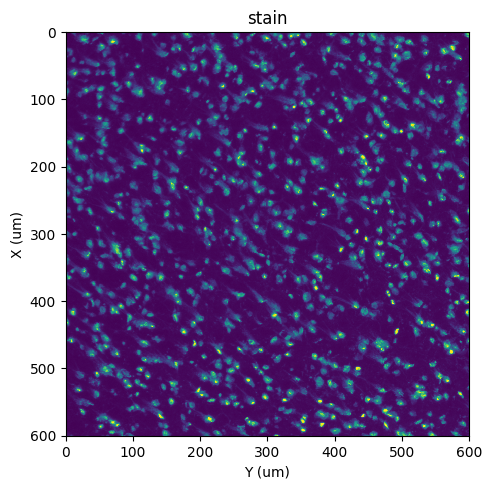

In [72]:
st.pl.imshow(adatasub, 'stain')

In [81]:
before = adatasub.layers['stain'].copy()
st.cs.refine_alignment(adatasub, mode='rigid', transform_layers=['stain'])

|-----> <select> stain layer in AnnData Object
|-----> <select> unspliced layer in AnnData Object
|-----> Refining alignment in rigid mode.


Loss -1.4816e-02: 100%|████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.23it/s]

|-----> Transforming layers ['stain']
|-----> <select> stain layer in AnnData Object
|-----> <insert> stain to layers in AnnData Object.


In [82]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(ncols=2, figsize=(16, 8), tight_layout=True)
axes[0].imshow(before)
st.pl.imshow(adatasub, 'unspliced', ax=axes[0], alpha=0.6, cmap='Reds', vmax=10, use_scale=False, save_show_or_return='return')
axes[0].set_title('before alignment')
st.pl.imshow(adatasub, 'stain', ax=axes[1], use_scale=False, save_show_or_return='return')
st.pl.imshow(adatasub, 'unspliced', ax=axes[1], alpha=0.6, cmap='Reds', vmax=10, use_scale=False, save_show_or_return='return')
axes[1].set_title('after alignment')

|-----> <select> unspliced layer in AnnData Object
|-----> <select> stain layer in AnnData Object
|-----> <select> unspliced layer in AnnData Object


Text(0.5, 1.0, 'after alignment')

|-----> <select> stain layer in AnnData Object
|-----> Constructing nuclei mask from staining image.
|-----> <insert> stain_mask to layers in AnnData Object.
|-----> <select> stain_mask layer in AnnData Object


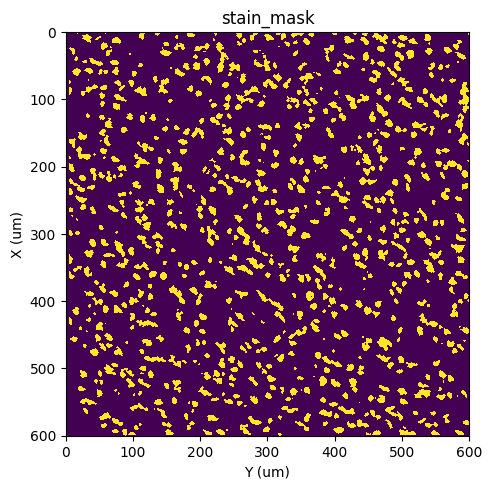

In [86]:
st.cs.mask_nuclei_from_stain(adatasub)
st.pl.imshow(adatasub, 'stain_mask')

In [85]:
st.cs.find_peaks_from_mask(adatasub, 'stain', 7)
st.cs.watershed(adatasub, 'stain', 5, out_layer='watershed_labels')

|-----> <select> stain_mask layer in AnnData Object
|-----> Finding peaks with minimum distance 7.
|-----> <insert> stain_distances to layers in AnnData Object.
|-----> <insert> stain_markers to layers in AnnData Object.
|-----> <select> stain layer in AnnData Object
|-----> <select> stain_mask layer in AnnData Object
|-----> <select> stain_markers layer in AnnData Object
|-----> Running Watershed.
|-----> <insert> watershed_labels to layers in AnnData Object.


In [94]:
# find xmin ymin
xall = []
yall = []
with open(tsv) as fr:
    header = fr.readline()
    for line in fr:
        gene, x, y, count = line.split()
        xall.append(int(x))
        yall.append(int(y))
xmin = np.min(xall)
ymin = np.min(yall)

In [87]:
watershed2x = {}
watershed2y = {}
for i in range(adatasub.layers['watershed_labels'].shape[0]):
    for j in range(adatasub.layers['watershed_labels'].shape[1]):
        if adatasub.layers['watershed_labels'][i, j] == 0:
            continue
        if adatasub.layers['watershed_labels'][i, j] in watershed2x:
            watershed2x[adatasub.layers['watershed_labels'][i, j]].append(i)
            watershed2y[adatasub.layers['watershed_labels'][i, j]].append(j)
        else:
            watershed2x[adatasub.layers['watershed_labels'][i, j]] = [i]
            watershed2y[adatasub.layers['watershed_labels'][i, j]] = [j]

watershed2center = {}
sizes = []
for nucleus in watershed2x:
    # Center for every cell 940
    watershed2center[nucleus] = [np.mean(watershed2x[nucleus]), np.mean(watershed2y[nucleus])]
    # Sizes for evary cell
    sizes.append(len(watershed2x[nucleus]))

In [91]:
# Find all the genes in the range
geneid = {}
genecnt = 0
id2gene = {}
with open(tsv) as fr:
    header = fr.readline()
    for line in fr:
        gene, x, y, count = line.split()
        if gene not in geneid:
            geneid[gene] = genecnt
            id2gene[genecnt] = gene
            genecnt += 1

In [97]:
geneid

{'0610005C13Rik': 0,
 '0610006L08Rik': 1,
 '0610009B22Rik': 2,
 '0610009O20Rik': 3,
 '0610010F05Rik': 4,
 '0610010K14Rik': 5,
 '0610012D04Rik': 6,
 '0610012G03Rik': 7,
 '0610025J13Rik': 8,
 '0610030E20Rik': 9,
 '0610031O16Rik': 10,
 '0610033M10Rik': 11,
 '0610037L13Rik': 12,
 '0610038B21Rik': 13,
 '0610039K10Rik': 14,
 '0610040B10Rik': 15,
 '0610040F04Rik': 16,
 '0610040J01Rik': 17,
 '0610043K17Rik': 18,
 '0710001A04Rik': 19,
 '1010001B22Rik': 20,
 '1010001N08Rik': 21,
 '1100001I12Rik': 22,
 '1110002E22Rik': 23,
 '1110002J07Rik': 24,
 '1110002L01Rik': 25,
 '1110002O04Rik': 26,
 '1110004E09Rik': 27,
 '1110004F10Rik': 28,
 '1110006O24Rik': 29,
 '1110008E08Rik': 30,
 '1110008F13Rik': 31,
 '1110008L16Rik': 32,
 '1110008P14Rik': 33,
 '1110012L19Rik': 34,
 '1110015O18Rik': 35,
 '1110017D15Rik': 36,
 '1110019B22Rik': 37,
 '1110019D14Rik': 38,
 '1110020A21Rik': 39,
 '1110028F18Rik': 40,
 '1110032A03Rik': 41,
 '1110032F04Rik': 42,
 '1110034G24Rik': 43,
 '1110035H17Rik': 44,
 '1110036E04Rik': 45

In [111]:
idx2exp = {}
downrs = 3
with open(tsv) as fr:
    header = fr.readline()
    for line in fr:
        gene, x, y, count = line.split()
        x = int(x) - xmin
        y = int(y) - ymin
        if gene not in geneid:
            continue
        if int(x) < int(stx) or int(x) >= int(stx) + int(patchsizex) or int(y) < int(sty) or int(y) >= int(sty) + int(patchsizey):
            continue
        idx = int(math.floor((int(x) - int(stx)) / downrs) * math.ceil(patchsizey / downrs) + math.floor((int(y) - int(sty)) / downrs))
        if idx not in idx2exp:
            idx2exp[idx] = {}
            idx2exp[idx][geneid[gene]] = int(count)
        elif geneid[gene] not in idx2exp[idx]:
            idx2exp[idx][geneid[gene]] = int(count)
        else:
            idx2exp[idx][geneid[gene]] += int(count)

In [112]:
len(idx2exp)

153802

In [113]:
from scipy.sparse import lil_matrix, csr_matrix, vstack

all_exp_merged_bins = lil_matrix((int(math.ceil(patchsizex / downrs) * math.ceil(patchsizey / downrs)), genecnt), dtype=np.int8)

In [114]:
all_exp_merged_bins.shape

(160000, 26177)

In [115]:
for idx in idx2exp:
    for gid in idx2exp[idx]:
        all_exp_merged_bins[idx, gid] = idx2exp[idx][gid]
        #print(idx, gid, idx2exp[idx][gid])
all_exp_merged_bins = all_exp_merged_bins.tocsr()

In [117]:
import anndata as ad

all_exp_merged_bins_ad = ad.AnnData(
        all_exp_merged_bins,
        obs=pd.DataFrame(index=[i for i in range(all_exp_merged_bins.shape[0])]),
        var=pd.DataFrame(index=[i for i in range(all_exp_merged_bins.shape[1])]),
    )

/home/yhchenmath/anaconda3/envs/cellseg/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning:

Transforming to str index.

/home/yhchenmath/anaconda3/envs/cellseg/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning:

Transforming to str index.



In [105]:
adatasub.layers['watershed_labels'].shape

(1200, 1200)

In [134]:
offsets = []
for dis in range(1, 11):
    for dy in range(-dis, dis + 1):
        offsets.append([-dis * downrs, dy * downrs])
    for dy in range(-dis, dis + 1):
        offsets.append([dis * downrs, dy * downrs])
    for dx in range(-dis + 1, dis):
        offsets.append([dx * downrs, -dis * downrs])
    for dx in range(-dis + 1, dis):
        offsets.append([dx * downrs, dis * downrs])

In [140]:
np.unique([x[0]/3 for x in offsets])

array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

In [141]:
# Save mid result
x_train_tmp = []
# X_train: for every exist transcript i j: [[n_neighbor, Gene_num],[n_neighbor, Gene_num],...]
x_train = []
# x_train_pos
x_train_pos = []
y_train = []
y_binary_train = []
x_train_bg_tmp = []
x_train_bg = []
x_train_pos_bg = []
y_train_bg = []
y_binary_train_bg = []
x_test_tmp = []
x_test = []
x_test_pos = []
n_neighbor = 50
for i in range(adatasub.layers['watershed_labels'].shape[0]):
    for j in range(adatasub.layers['watershed_labels'].shape[1]):
        if (not i % downrs == 0) or (not j % downrs == 0):
            continue
        idx = int(math.floor(i / downrs) * math.ceil(patchsizey / downrs) + math.floor(j / downrs))
        if adatasub.layers['watershed_labels'][i, j] > 0:
            if idx >= 0 and idx < all_exp_merged_bins.shape[0] and np.sum(all_exp_merged_bins[idx, :]) > 0:
                x_train_sample = [all_exp_merged_bins[idx, :]]
                x_train_pos_sample = [[i, j]]
                y_train_sample = [watershed2center[adatasub.layers['watershed_labels'][i, j]]]
                for dx, dy in offsets:
                    if len(x_train_sample) == n_neighbor:
                        break
                    x = i + dx
                    y = j + dy
                    if x < 0 or x >= adatasub.layers['watershed_labels'].shape[0] or y < 0 or y >= \
                            adatasub.layers['watershed_labels'].shape[1]:
                        continue
                    idx_nb = int(
                        math.floor(x / downrs) * math.ceil(patchsizey / downrs) + math.floor(y / downrs))
                    if idx_nb >= 0 and idx_nb < all_exp_merged_bins.shape[0] and np.sum(
                            all_exp_merged_bins[idx_nb, :]) > 0:
                        x_train_sample.append(all_exp_merged_bins[idx_nb, :])
                        x_train_pos_sample.append([x, y])
                if len(x_train_sample) < n_neighbor:
                    continue
                x_train_tmp.append(x_train_sample)
                if len(x_train_tmp) > 500:
                    x_train.extend(x_train_tmp)
                    x_train_tmp = []
                x_train_pos.append(x_train_pos_sample)
                y_train.append(y_train_sample)
                y_binary_train.append(1)
        else:
            if idx >= 0 and idx < all_exp_merged_bins.shape[0] and np.sum(all_exp_merged_bins[idx, :]) > 0:
                backgroud = True
                for nucleus in watershed2center:
                    # If closed to a nuleus, then background = False
                    if (i - watershed2center[nucleus][0]) ** 2 + (
                            j - watershed2center[nucleus][1]) ** 2 <= 900 or adatasub.layers['stain'][
                        i, j] > 10:
                        backgroud = False
                        break
                if backgroud:
                    # If to much bg, then continue
                    if len(x_train_bg) + len(x_train_bg_tmp) >= len(x_train) + len(x_train_tmp):
                        continue
                    x_train_sample = [all_exp_merged_bins[idx, :]]
                    x_train_pos_sample = [[i, j]]
                    y_train_sample = [[-1, -1]]
                    for dx, dy in offsets:
                        if len(x_train_sample) == n_neighbor:
                            break
                        x = i + dx
                        y = j + dy
                        if x < 0 or x >= adatasub.layers['watershed_labels'].shape[0] or y < 0 or y >= \
                                adatasub.layers['watershed_labels'].shape[1]:
                            continue
                        idx_nb = int(
                            math.floor(x / downrs) * math.ceil(patchsizey / downrs) + math.floor(y / downrs))
                        if idx_nb >= 0 and idx_nb < all_exp_merged_bins.shape[0] and np.sum(
                                all_exp_merged_bins[idx_nb, :]) > 0:
                            x_train_sample.append(all_exp_merged_bins[idx_nb, :])
                            x_train_pos_sample.append([x, y])
                    if len(x_train_sample) < n_neighbor:
                        continue
                    x_train_bg_tmp.append(x_train_sample)
                    if len(x_train_bg_tmp) > 500:
                        x_train_bg.extend(x_train_bg_tmp)
                        x_train_bg_tmp = []
                    # print(len(x_train_bg_tmp))
                    x_train_pos_bg.append(x_train_pos_sample)
                    y_train_bg.append(y_train_sample)
                    y_binary_train_bg.append(0)
                else:
                    x_test_sample = [all_exp_merged_bins[idx, :]]
                    x_test_pos_sample = [[i, j]]
                    for dx, dy in offsets:
                        if len(x_test_sample) == n_neighbor:
                            break
                        x = i + dx
                        y = j + dy
                        if x < 0 or x >= adatasub.layers['watershed_labels'].shape[0] or y < 0 or y >= \
                                adatasub.layers['watershed_labels'].shape[1]:
                            continue
                        idx_nb = int(
                            math.floor(x / downrs) * math.ceil(patchsizey / downrs) + math.floor(y / downrs))
                        if idx_nb >= 0 and idx_nb < all_exp_merged_bins.shape[0] and np.sum(
                                all_exp_merged_bins[idx_nb, :]) > 0:
                            x_test_sample.append(all_exp_merged_bins[idx_nb, :])
                            x_test_pos_sample.append([x, y])
                    if len(x_test_sample) < n_neighbor:
                        continue
                    x_test_tmp.append(x_test_sample)
                    if len(x_test_tmp) > 500:
                        x_test.extend(x_test_tmp)
                        x_test_tmp = []
                    x_test_pos.append(x_test_pos_sample)  #

x_train.extend(x_train_tmp)
x_train_bg.extend(x_train_bg_tmp)
x_test.extend(x_test_tmp)

x_train = np.array(x_train)
x_train_pos = np.array(x_train_pos)
y_train = np.vstack(y_train)
y_binary_train = np.array(y_binary_train)
x_train_bg = np.array(x_train_bg)
x_train_pos_bg = np.array(x_train_pos_bg)
y_train_bg = np.vstack(y_train_bg)
y_binary_train_bg = np.array(y_binary_train_bg)

In [174]:
np.vstack(x_train).shape

(23692, 2)

In [161]:
y_train.shape

(23692, 2)

In [152]:

from torch import nn

encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
src = torch.rand(10, 32, 512)
out = encoder_layer(src)

In [153]:
out.shape

torch.Size([10, 32, 512])

In [ ]:
def dir_to_class(y_dir, class_num):
    y_dir_class = []
    for i in range(len(y_dir)):
        x, y = y_dir[i]
        if x == -9999:
            y_vec = np.zeros(class_num)
            y_dir_class.append(y_vec)
        else:
            if y == 0 and x > 0:
                deg = np.arctan(float('inf'))
            elif y == 0 and x < 0:
                deg = np.arctan(-float('inf'))
            elif y == 0 and x == 0:
                deg = np.arctan(0)
            else:
                deg = np.arctan((x/y))
            if (x > 0 and y < 0) or (x <= 0 and y < 0):
                deg += np.pi
            elif x < 0 and y >= 0:
                deg += 2 * np.pi
            cla = int(deg / (2 * np.pi / class_num))
            y_vec = np.zeros(class_num)
            y_vec[cla] = 1
            y_dir_class.append(y_vec)
    return np.array(y_dir_class)


In [178]:
x = torch.randn(3,5)
y = torch.empty(3, dtype=torch.long).random_(5)
x,y

(tensor([[ 0.5716, -0.0238,  0.3033,  1.6782, -0.4685],
         [-1.7770, -1.2269, -0.2390, -0.7211, -2.8930],
         [-0.2507,  0.0625, -0.7068,  0.4660, -0.9381]]),
 tensor([1, 3, 0]))

In [190]:
label = torch.empty(3, dtype=torch.long).random_(2)
label

tensor([1, 0, 1])

In [192]:
loss = nn.CrossEntropyLoss(reduction = 'none')
(loss(x, y) * label).mean()

tensor(1.3496)

In [200]:
x_b = torch.randn(3, 1)
loss = nn.BCEWithLogitsLoss()
loss(x_b.squeeze(1), label)

RuntimeError: result type Float can't be cast to the desired output type Long

In [206]:
y_train.shape

(23692, 2)